In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [6]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [517]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .35 .25; .035 .15 .63]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])


transition_matrix = [.85 .15;.2 .8]

states_zero = [.9, .1]
X = [.12, .06]


n_steps = 1000
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, [Β1, Β2], [Σ1, Σ2], X, n_steps, 1)[:,:,1]'

1000×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.238264    0.0910862
 0.143753    0.1092
 0.0618532   0.0878132
 0.0305467   0.0611787
 0.12937     0.119683
 0.136388    0.104368
 0.139789    0.100934
 0.127652    0.124441
 0.120907    0.120163
 0.104915    0.117798
 ⋮           
 0.1129      0.192378
 0.15021     0.133325
 0.120517    0.174589
 0.0943442   0.1316
 0.00127257  0.0979286
 0.0116954   0.109723
 0.241313    0.116084
 0.19407     0.107914
 0.167149    0.121591

In [518]:
count(x -> x==1, test_regimes)

852

In [519]:
Y = collect(test_returns[2:end,:])
T = n_steps
p = 1
X = hcat(ones(T-1), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [475]:
n_samples = 5000
T = 999

result = zeros(Int64, n_samples, T)

for n in 1:n_samples
    result[n, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
end

result



5000×999 Matrix{Int64}:
 1  1  1  1  1  2  2  2  2  2  2  2  1  …  1  1  1  2  2  1  1  1  2  1  1  1
 1  1  1  1  2  2  1  2  2  2  2  2  2     1  2  1  1  2  1  1  1  1  1  1  1
 1  1  1  1  1  1  2  2  2  1  1  1  2     1  1  2  2  2  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  2  2  2  2  1  2     1  1  1  1  2  2  2  1  1  1  1  1
 1  1  1  1  1  1  1  2  2  2  2  2  1     1  1  1  2  2  2  2  1  1  1  1  1
 1  1  1  1  1  1  2  2  2  2  2  1  1  …  1  1  1  1  2  2  2  1  1  1  1  1
 1  1  1  1  1  2  2  2  2  2  1  2  1     2  1  1  2  2  1  1  1  1  1  1  1
 1  1  1  1  1  2  2  2  1  2  2  2  1     1  1  1  1  2  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  2  1  2  1  1  1     1  1  2  2  2  2  1  1  1  1  1  1
 1  1  1  1  1  1  1  2  1  1  1  1  1     1  1  1  2  2  1  1  1  1  1  1  2
 ⋮              ⋮              ⋮        ⋱           ⋮              ⋮        
 1  1  1  1  1  2  2  2  2  2  2  1  1     1  1  1  1  2  2  2  2  2  2  1  1
 2  2  1  1  1  2  2  2  1  1  1  1  1   

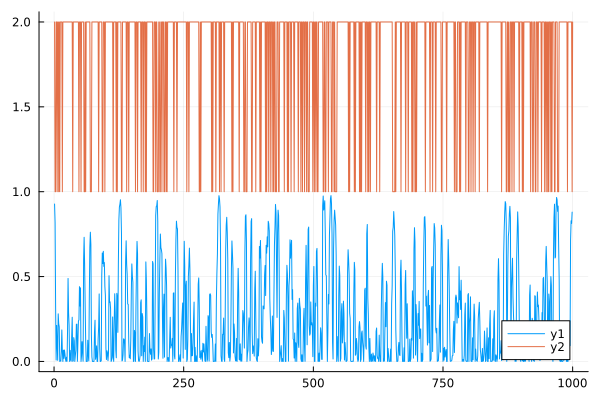

In [435]:
r1 = [count(x -> x ==1, result[:,t]) for t in 1:T ] / n_samples

plot(r1)
plot!(test_regimes)


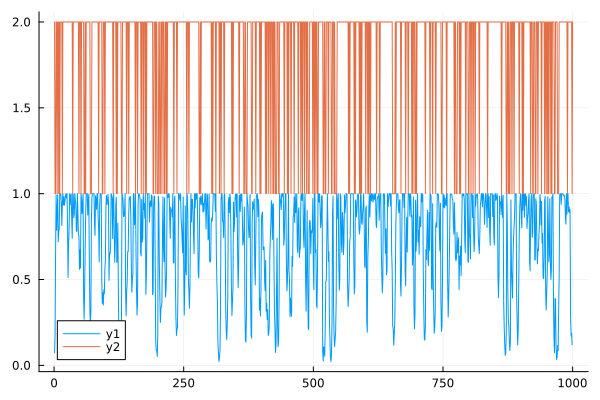

In [436]:
r2 = [count(x -> x ==2, result[:,t]) for t in 1:T ] / n_samples

plot(r2)
plot!(test_regimes)

In [437]:
n = count_regime_transitions(result[1, :], 2)


2×2 Matrix{Float64}:
 185.0   99.0
  99.0  615.0

In [438]:
n ./ sum(n, dims=2) 

2×2 Matrix{Float64}:
 0.651408  0.348592
 0.138655  0.861345

In [439]:
t_m = zeros(n_samples, 2, 2)
for n in 1:n_samples
  t_m[n, :, :] = sample_transition_matrix(result[n, :], 2)
end

mean_tm = mean(t_m, dims=1)[1,:,:]

mean_tm

2×2 Matrix{Float64}:
 0.654494  0.345506
 0.120952  0.879048

In [440]:
filter_X(Y, result[1,:], 1)

285×2 Matrix{Float64}:
 0.23598    0.113993
 0.0836238  0.105948
 0.0155074  0.112831
 0.188138   0.155806
 0.32731    0.200175
 0.339803   0.217962
 0.0631067  0.125734
 0.298334   0.211907
 0.155155   0.0928375
 0.121916   0.104384
 ⋮          
 0.275392   0.090084
 0.0775768  0.115688
 0.068811   0.106057
 0.0873357  0.118795
 0.086928   0.10907
 0.133335   0.0997208
 0.0554133  0.0622153
 0.288484   0.111999
 0.215688   0.125393

In [512]:
k = 2
cov_sample =zeros(n_samples, k, 2, 2)

for n in 1:n_samples
    cov_sample[n, :, :, :] = sample_covariance(Y, X, Β, result[n,:], 2)
end

cov1_mean = mean(cov_sample[:,1,:,:], dims=1)[1, :, :]
cov2_mean = mean(cov_sample[:,2,:,:], dims=1)[1, :, :] 


DimensionMismatch: DimensionMismatch: tried to assign 2-element array to 1×2×2×2 destination

In [442]:
display(cov2cor(cov1_mean))
display(sqrt.(diag(cov1_mean)))
display(cov2cor(cov2_mean))
display(sqrt.(diag(cov2_mean)))

2×2 Matrix{Float64}:
 1.0       0.301259
 0.301259  1.0

2-element Vector{Float64}:
 0.005546640166929945
 0.001937853311231157

2×2 Matrix{Float64}:
 1.0       0.419524
 0.419524  1.0

2-element Vector{Float64}:
 0.007078986508583427
 0.0012913381744821624

8-element Vector{Float64}:
 2.5608805792423217e-5
 5.4656349815134386e-5
 2.1413922114585952e-6
 3.8945873819594594e-6
 2.1413922114585952e-6
 3.8945873819594594e-6
 3.4989733975045367e-6
 1.6567666267479178e-6

In [443]:
n_samples = 5000

Β_sample = zeros(n_samples, 2, 3, 2)

for n in 1:n_samples
    Βn = sample_betas(Y,X,result[1,:], cov_sample[1,:,:,:],2)
    Β_sample[n,:,:,:] =  Βn
end

display(mean(Β_sample[:,1,:,:], dims=1))
display(mean(Β_sample[:,2,:,:], dims=1))


1×3×2 Array{Float64, 3}:
[:, :, 1] =
 0.0805372  0.281961  0.247305

[:, :, 2] =
 0.0318184  0.109941  0.587101

1×3×2 Array{Float64, 3}:
[:, :, 1] =
 -0.0454886  0.280071  0.400009

[:, :, 2] =
 0.0326407  0.131602  0.66

In [522]:
n_burn = 1000
n_sample = 500
Σ0 = Σ
regimes, t_m, Σ_post = msvar(Y, X, transition_matrix, Β, Σ0, n_burn, n_sample)

([1 1 … 1 1; 2 2 … 1 1; … ; 1 2 … 2 1; 1 1 … 2 1], [0.8891727127347173 0.410021326378851; 0.5960012348966409 0.17932071286802126; … ; 0.48641706137236285 0.49047848244056735; 0.5319277343015618 0.5109038800668884;;; 0.11082728726528253 0.589978673621149; 0.4039987651033591 0.8206792871319786; … ; 0.5135829386276373 0.5095215175594326; 0.4680722656984384 0.4890961199331117], Vector{Any}[[[8.258764811693783e-6 9.340033862376658e-7; 9.340033862376658e-7 1.1158992508979701e-6], [0.00010646579341085147 7.106874041763386e-6; 7.106874041763386e-6 5.707700794753233e-6]], [[3.912904604585636e-5 2.308843605813376e-6; 2.308843605813376e-6 3.377601843299326e-6], [2.0712614798525092e-5 -7.28919738606833e-7; -7.28919738606833e-7 1.692042884178891e-6]], [[1.720211009651717e-5 9.264589756461721e-7; 9.264589756461721e-7 1.5922840907101282e-6], [4.192761101946137e-5 -1.2058905007185196e-6; -1.2058905007185196e-6 4.051810653173409e-6]], [[2.0202587302780695e-5 1.7552293209253149e-6; 1.7552293209253149e-6

In [523]:
mean(t_m, dims=1)[1,:,:]

2×2 Matrix{Float64}:
 0.495658  0.504342
 0.532205  0.467795

In [524]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:T ] / n_samples

plot(r1)
plot!(test_regimes)

BoundsError: BoundsError: attempt to access 1500×999 Matrix{Int64} at index [1:1500, 1000]

In [507]:
Σ_post[1][1,:]

BoundsError: BoundsError: attempt to access 2×2×2 Array{Float64, 3} at index [1, 1:2]

In [487]:
sp = []

push!(sp, Σ)
push!(sp, Σ)
push!(sp, Σ+Σ)


3-element Vector{Any}:
 [[0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009], [0.0324 0.002205; 0.002205 0.0012250000000000002]]
 [[0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009], [0.0324 0.002205; 0.002205 0.0012250000000000002]]
 [[0.0128 0.0014399999999999999; 0.0014399999999999999 0.0018], [0.0648 0.00441; 0.00441 0.0024500000000000004]]

In [489]:
mean(map(x -> x[1],sp))

2×2 Matrix{Float64}:
 0.00853333  0.00096
 0.00096     0.0012